## Principal Component Analysis and Clustering
### Purpose:
**Identify 6 significant clusters in the provided dataset for the marketing department that will transform how customers are viewed by the business**

### Data Exploration:


In [ ]:
libname pca '/folders/myfolders/Assign1';

In [4]:
title'First 10 observation';
proc print data=pca.dev2 (obs=10);
run;

Obs,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default
1,10000,10000,10000,0.1349,230.05,C,32000,13.05,0,1,5,0,16525,0.473,10,2763.39,2763.39,7371.41,7371.41,7236.61,134.80,0,0,0,230.05,0,0,112399,0,0,0,0,67,0,.,0,0,9296,47.3,34900,1,0,1,0,22480,18375,47.3,94,206,84,67,1,84,6,0,2,2,4,7,2,4,7,2,5,0,0,0,0,100.0,50.0,0,0,141464,16525,34900,0,0
2,32000,32000,32000,0.1399,1093.53,C,110000,17.30,0,0,9,0,40816,0.967,15,29813.31,29813.31,3218.41,3218.41,2186.69,1031.72,0,0,0,1093.53,0,0,216674,1,3,0,1,14,25826,50.7,1,2,6159,71.5,42200,0,2,0,3,24075,781,95.5,98,289,3,3,1,3,.,0,4,5,4,7,4,5,10,5,9,0,0,0,1,93.3,75.0,0,0,283160,66642,17200,50960,0
3,3000,3000,3000,0.1559,104.87,C,42000,8.34,0,0,5,1,2673,0.486,16,2799.74,2799.74,308.11,308.11,200.26,107.85,0,0,0,104.87,0,0,14494,1,2,4,6,1,11821,100.2,0,0,2673,83.8,5500,0,5,0,6,2899,2827,48.6,155,225,45,1,0,45,.,0,1,1,3,6,8,3,7,1,5,0,0,0,4,100.0,0.0,1,0,17295,14494,5500,11795,0
4,9000,9000,9000,0.1399,307.56,C,125000,30.21,2,2,13,0,26776,0.610,32,8384.98,8384.98,905.19,905.19,615.02,290.17,0,0,0,307.56,0,0,164446,1,4,1,3,3,137670,73.4,0,5,4477,68.8,43900,4,8,4,8,12650,292,96.8,122,118,21,3,1,30,2,1,2,6,2,6,15,9,16,6,13,0,0,1,1,90.6,100.0,0,0,205358,164446,9000,161458,0
5,10000,10000,10000,0.1099,327.34,B,41000,16.48,2,2,15,0,5608,0.342,33,9286.23,9286.23,966.76,966.76,713.77,252.99,0,0,0,327.34,1,0,7704,1,1,0,0,41,2096,24.4,1,4,2452,30.8,16400,0,0,2,4,550,3714,43.7,90,314,2,2,0,15,2,0,2,10,2,8,4,14,29,10,14,0,1,0,1,87.9,66.7,0,0,24999,7704,6600,8599,0
6,8000,8000,8000,0.1449,275.33,C,75000,22.69,1,1,26,0,22472,0.316,68,7457.31,7457.31,809.89,809.89,542.69,267.20,0,0,0,275.33,0,0,138771,2,2,0,4,13,14592,76.3,3,7,4196,41.1,71100,1,14,5,11,6034,22366,30.5,130,303,1,1,2,1,0,0,5,10,9,18,22,23,44,10,26,0,0,0,3,94.1,22.2,0,0,204661,37064,32200,19120,0
7,20000,20000,20000,0.1699,712.96,D,71000,18.56,0,1,32,0,19690,0.402,54,18692.28,18692.28,2091.69,2091.69,1307.72,783.97,0,0,0,712.96,0,51,263956,3,16,2,7,1,61616,93.2,3,6,3948,70.6,49000,0,4,3,15,8515,345,95.5,150,168,4,1,4,16,4,0,2,9,2,8,22,15,28,9,32,0,0,0,7,96.3,100.0,0,0,300906,81306,7600,66132,0
8,4800,4800,4800,0.1349,162.87,C,111000,26.63,0,0,18,0,30946,0.746,41,4469.59,4469.59,456.23,456.23,330.41,125.82,0,0,0,162.87,0,0,133123,1,3,0,2,16,102177,19.5,1,5,5805,57.7,41500,3,2,0,7,7396,3788,84.6,110,153,2,2,0,22,16,0,9,13,10,11,21,15,20,13,18,0,0,0,1,100.0,80.0,0,0,165339,133123,24600,123839,0
9,35000,35000,35000,0.2399,1372.97,E,180000,15.61,0,3,14,0,25635,0.671,29,32939.57,32939.57,4002.29,4002.29,2060.43,1941.86,0,0,0,1372.97,0,0,84853,2,4,0,0,32,59218,68.8,3,4,6162,67.9,38200,1,4,4,4,6061,446,97.6,154,150,0,0,1,9,0,0,5,6,5,11,10,10,18,6,14,0,0,0,3,100.0,100.0,0,0,156126,84853,18800,117926,0
10,12000,12000,12000,0.1559,419.46,C,70000,22.86,0,1,18,0,20075,0.567,45,11199.00,11199.00,1154.45,1154.45,801.00,353.45,0,0,0,419.46,0,0,156605,2,3,1,1,4,31445,73.6,1,5,6031,65.9,35400,0,2,3,6,9212,140,99.1,120,190,2,2,1,13,2,0,5,8,5,13,12,14,32,8,18,0,0,0

#### Dataset Contents

In [9]:
title 'Dataset contents';
ods exclude enginehost;
proc contents data=pca.dev2 varnum;
run;

In the given Bank's customer dataset, there there are 27572 observations and 77 variables. All the variables are numeric other than Grade which is char variable.

#### Descriptive Statistics

In [11]:
ods nonproctitle;
proc means data=pca.dev2 n nmiss min max mean std  kurt skew;
run;

Variable,N,N Miss,Minimum,Maximum,Mean,Std Dev,Kurtosis,Skewness
loan_amnt funded_amnt funded_amnt_inv int_rate installment annual_inc dti delinq_2yrs inq_last_6mths open_acc pub_rec revol_bal revol_util total_acc out_prncp out_prncp_inv total_pymnt total_pymnt_inv total_rec_prncp total_rec_int total_rec_late_fee recoveries collection_recovery_fee last_pymnt_amnt acc_now_delinq tot_coll_amt tot_cur_bal open_acc_6m open_il_6m open_il_12m open_il_24m mths_since_rcnt_il total_bal_il il_util open_rv_12m open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi total_cu_tl inq_last_12m acc_open_past_24mths avg_cur_bal bc_open_to_buy bc_util mo_sin_old_il_acct mo_sin_old_rev_tl_op mo_sin_rcnt_rev_tl_op mo_sin_rcnt_tl mort_acc mths_since_recent_bc mths_since_recent_inq num_accts_ever_120_pd num_actv_bc_tl num_actv_rev_tl num_bc_sats num_bc_tl num_il_tl num_op_rev_tl num_rev_accts num_rev_tl_bal_gt_0 num_sats num_tl_120dpd_2m num_tl_30dpd num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75 pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit total_il_high_credit_limit default,27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27560 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 26768 27572 23772 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 27255 27241 26768 27572 27572 27572 27572 27265 24643 27572 27572 27572 27572 27572 27572 27572 27572 27572 27572 26229 27572 27572 27572 27572 27255 27572 27572 27572 27572 27572 27572 27572,0 0 0 0 0 0 0 0 0 0 0 0 12 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 804 0 3800 0 0 0 0 0 0 0 0 0 0 317 331 804 0 0 0 0 307 2929 0 0 0 0 0 0 0 0 0 0 1343 0 0 0 0 317 0 0 0 0 0 0 0,1000.00 1000.00 1000.00 0.0532000 30.1200000 0 0 0 0 1.0000000 0 0 0 2.0000000 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.0000000 4.0000000 0 0 0 0 0 0 0 0 0 0 0 0 2.0000000 0 1.0000000 0 0 0 0 14.3000000 0 0 0 2700.00 0 0 0 0,40000.00 40000.00 40000.00 0.3099000 1517.43 9225000.00 9999.00 20.0000000 5.0000000 71.0000000 31.0000000 882984.00 1.5430000 144.0000000 38956.11 38956.11 39927.86 39927.86 39020.54 4917.62 116.2400000 0 0 36242.23 4.0000000 63951.00 2326419.00 17.0000000 39.0000000 25.0000000 51.0000000 334.0000000 774639.00 229.8000000 20.0000000 43.0000000 243997.00 169.5000000 1084400.00 19.0000000 39.0000000 31.0000000 56.0000000 275482.00 264512.00 166.7000000 615.0000000 745.0000000 306.0000000 171.0000000 37.0000000 472.0000000 25.0000000 34.0000000 35.0000000 47.0000000 54.0000000 70.0000000 128.0000000 61.0000000 92.0000000 47.0000000 71.0000000 3.0000000 3.0000000 20.0000000 25.0000000 100.0000000 100.0000000 6.0000000 30.0000000 3229815.00 882984.00 368500.00 870000.00 1.0000000,14824.54 14824.18 14817.77 0.1239266 445.2166053 77795.70 21.1208291 0.3639562 0.5172276 11.8524953 0.2507979 16764.09 0.5022455 24.3361381 13479.21 13473.45 1992.67 1991.78 1344.97 647.5591343 0.1394201 0 0 457.8396743 0.0066734 256.6784782 140937.58 0.9519440 2.8339257 0.7252648 1.5772523 21.6819710 34805.93 70.9311249 1.3393660 2.8521326 5675.86 60.0201763 33867.85 0.9321413 1.4795445 2.0979980 4.6776803 13303.87 10507.19 57.9976065 126.1800284 182.4536124 13.7164152 8.2038300 1.5334035 24.4837337 6.9945624 0.5239736 3.6384013 5.6761932 4.7413681 7.5624184 8.5637603 8.2953721 13.9892645 5.5968736 11.8001959 0.0012200 0.0040258 0.0918686 2.1891412 93.6786885 42.1390754 0.1386189 0.0724648 175894.36 51563.70 22055.27 44293.22 0.0154142,8932.60 8932.59 8930.86 0.0489008 269.6470073 83435.72 147.5376534 0.9622504 0.8205323 5.8043591 0.6750724 24063.26 0.2423468 11.9954876 8283.75 8282.25 1451.31 1450.80 1144.28 556.1270199 2.2473621 0 0 471.9813272 0.0926700 1599.30 157090.59 1.1601218 3.1405978 0.9815660 1.6393971 26.3684671 41504.60 23.1807866 1.5160997 2.5932127 5538.52 20.1307022 35004.41 1.4468199 2.6773428 2.3941917 3.2809658 15974.53 15384.92 28.3109883 52.8488914 98.0945964 16.93

There are 7601 missing values, which will be ignored in PCA and Clustering proceedure. A lot of variables are heavily skewed. Also, some variables have really strong kurtosis ­ which can mean that people with respect to those variables lie in a similar bracket or have similar behaviour. Another noticeable aspect is both recoveries and collection_recovery_fee are 0 values. Hennce, we can ignore them in our principal component proceedure

### Principal Component prodeedure

With the given dataset, where n = 27001 and 77 variables, it is imperative to reduce the dataset to smaller set of variables to derive a conclusion. With Multi-collinearity, two or more variables can share the same dimension. Each dimension can be viewed as 77 dimensional graph when the data is projected as orthonormal. Hence, PCA proceedure is used to reduce the dimension of the data and it gives us a direction that approximately how many variables can be used to explain the data


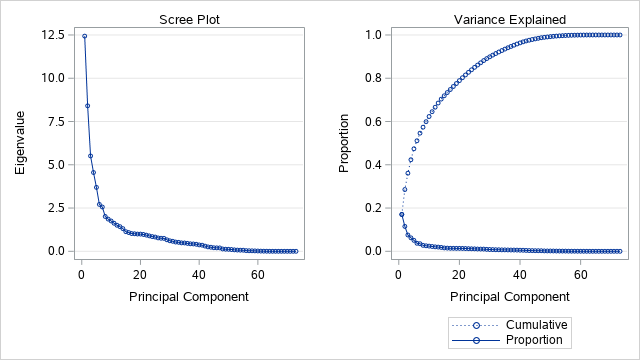
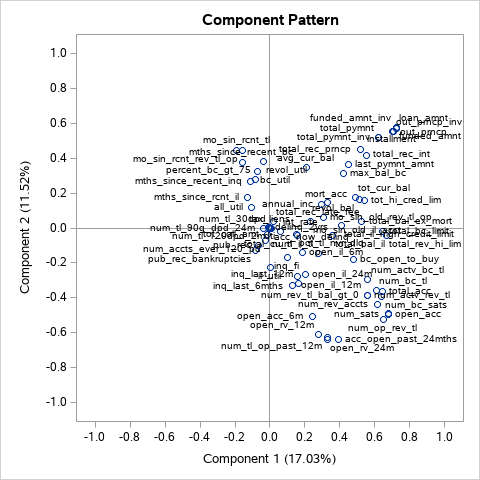
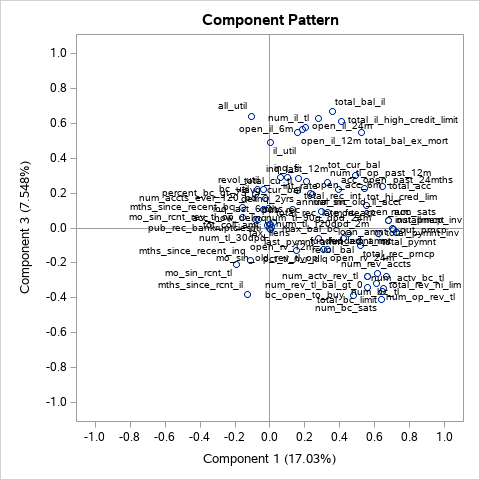
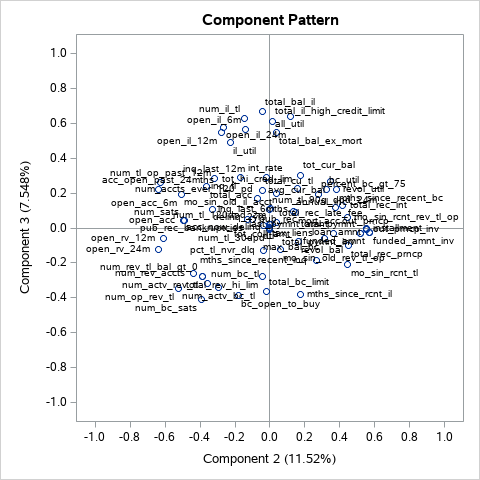

In [13]:
ods select Eigenvalues ScreePlot PatternPlot  ;
proc princomp data=pca.dev2 (drop=default recoveries collection_recovery_fee )
out=dev_pca_score outstat= dev_pca_stat
plots(only)=(scree
pattern(ncomp=3)
score(ellipse ncomp=3));
run;

The variance of each principal component is implied eigen values of the component. Higher the eigen value, better the variance explained by the component. From the above Eigenvalues of the Correlation Matrix it can be observed that First 18 principal components explain 76% of total variation, considering eigenvalue of 1 as the threshhold. The same aspect can be also observed in our scree plot ­ that the curve is almost flat after principal component 18 and eigen value 1, which means other principal components contributes very less to explain variation.

Hence, for now we can ignore principal components greater than 18

### Standardization

In [ ]:
proc stdize data = dev_pca_score out = dev_pca_score_std;
run;

In [26]:
title 'standardization confirmed';
ods nonproctitle;
proc means data = dev_pca_score_std std;
var prin1--prin73;
run;


Variable,Std Dev
Prin1 Prin2 Prin3 Prin4 Prin5 Prin6 Prin7 Prin8 Prin9 Prin10 Prin11 Prin12 Prin13 Prin14 Prin15 Prin16 Prin17 Prin18 Prin19 Prin20 Prin21 Prin22 Prin23 Prin24 Prin25 Prin26 Prin27 Prin28 Prin29 Prin30 Prin31 Prin32 Prin33 Prin34 Prin35 Prin36 Prin37 Prin38 Prin39 Prin40 Prin41 Prin42 Prin43 Prin44 Prin45 Prin46 Prin47 Prin48 Prin49 Prin50 Prin51 Prin52 Prin53 Prin54 Prin55 Prin56 Prin57 Prin58 Prin59 Prin60 Prin61 Prin62 Prin63 Prin64 Prin65 Prin66 Prin67 Prin68 Prin69 Prin70 Prin71 Prin72 Prin73,1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 0 0


### Perfoming Clustering

After performing principal component analysis, the next step is using Fastclus to perform clustering and identify 6 large clusters. Few iterations were tried with different cluster sizes. The Fastclus operation uses K-Means clustering, which is an iterative approach that helps to identify the approximately equal sized clusters with a defined spread. 

A set of values are selected as Initial Seeds for reference i.e. mean and then the nearest values are formed as temporary clusters and replaced with the mean of new clusters and this is repeated iteratively until there is no change in clusters.

In [28]:
title'Clustering';
ods select initialseeds mindist IterHistory ConvergenceStatus Criterion ClusterSum
 PseudoFStat ApproxExpOverAllRSq ;
proc fastclus data=  dev_pca_score_std out = dev_clus outstat=dev_clus_stat
maxclusters=14 l=2 maxiter=200;
var prin1 prin2 prin3 prin4 prin5 prin6 prin7 prin8 prin9 prin10
prin11 prin12 prin13 prin14 prin15 prin16 prin17 prin18;
run;

 ‘Complete convergence is satisfied’ implies that the final SEEDS is equal to the cluster mean. The summary of statistics of clusters displays the frequency of observations in each cluster and the root mean square deviation. The last column displays the distance from the centre of the cluster to the centre of the nearest cluster. Six appropriate sized clusters are obtained with 14 clusters and at 188th iteration.
 
Cluster 1,4,6,9,12,14 are our significant clusters and cluster 1 which is the largest cluster is observed to be the nearest cluster of all. Also, higher CCC values indicate good clustering generally expected to be more than 2 or 3. Higher F Statistic and CCC implies that the clustering solution is good.

### Now scoring the New Dataset for clustering

The new data is then scored with the old statistics and the segments are identified. The scoring of new data set consists of the following steps: 

1. The outputs stats from the PRINCOMP is used to score the new dataset 
2. The output from STDIZE is used as input to standardize the new scored dataset 
3. The output stat from the FASTCLUS is used as input stat for the new dataset 

#### Scoring PCA

In [ ]:
proc score data=pca.new2 score=dev_pca_stat out= new_pca_score_from_devstat;
run;

In [ ]:
proc fastclus instat= dev_clus_stat data= new_pca_score_from_devstat out=new_clus;
var prin1 prin2 prin3 prin4 prin5 prin6 prin7 prin8 prin9 prin10
prin11 prin12 prin13 prin14 prin15 prin16 prin17 prin18;
run;

**Clustering adds two new columns to the produced clustering output**

1. Cluster - That defines the clusters 
2. Distance - That defines the distance

In [29]:
title 'clusters for the new dataset';
proc freq data=new_clus;
tables cluster;
run;

From the above table it can be observed that for the new dataset, the significant clusters are still the same - (1,4,6,9,12,14) . They obviously can not have the same frequency but their frequency is distributed in similar way.

### Merging the clustering output to the original dataset

In [ ]:
data clus_profile;
merge pca.dev2 dev_clus (keep=cluster);
run;

### Insights and Comments

#### Profiling Cluster

Variables were selected using some business sense!

In [30]:
proc tabulate data = clus_profile;
class cluster;
var revol_bal loan_amnt all_util annual_inc  num_sats total_il_high_credit_limit
total_acc int_rate percent_Bc_Gt_75 inq_fi num_il_tl delinq_2Yrs pub_rec_bankruptcies tot_cur_bal;

tables (cluster all), n pctn (revol_bal loan_amnt all_util annual_inc  num_sats total_il_high_credit_limit
total_acc int_rate percent_Bc_Gt_75 inq_fi num_il_tl delinq_2Yrs pub_rec_bankruptcies tot_cur_bal)*mean;
run;

Cluster     | Analysis                                | Solution/How to add value?
-------     | -----------------------------------     | --------------------------
Cluster 1   |Medium income, less loans, less deliquency| Provide them with more smaller credits and loans as they are less risky
Cluster 4   |Medium income, and less credit usage| Customers who can be persuaded to get more loans (smaller loans) - but monitor activities
Cluster 6   |Highest income, wealthy segment, not too high credit limit| Try to gain loyalty amongst these customers, get them to invest more - Design a marketing campaign focusing this segment
Cluster 9   |Medium high income, very high current a/c balance|Customer who can be induced to invest their current a/c funds
Cluster 12  |Wealthiest and least exploted segment|Lower interest rates to induce more credit and try to gain loyalty
Cluster 14  |Medium high income, high revolving balance and hight loan amount|Some risk of defaultin - monitoring required